In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from collections import Counter
!pip install -U gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('train.csv')
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
print("\nFeatures Present in the Dataset: \n", df.columns)
shape=df.shape
print("\nTotal Number of Rows : ",shape[0])
print("Total Number of Features : ", shape[1])
print("\n\nData Types of Features :\n", df.dtypes)
print("\nDataset contains any NaN/Empty cells : ", df.isnull().values.any())
print("\nTotal number of empty rows in each feature:\n", df.isnull().sum(),"\n\n")
print("Total number of unique values in each feature:")
for col in df.columns.values:
    print("Number of unique values of {} : {}".format(col, df[col].nunique()))


Features Present in the Dataset: 
 Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

Total Number of Rows :  159571
Total Number of Features :  8


Data Types of Features :
 id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

Dataset contains any NaN/Empty cells :  False

Total number of empty rows in each feature:
 id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64 


Total number of unique values in each feature:
Number of unique values of id : 159571
Number of unique values of comment_text : 159571
Number of unique values of malignant : 2
Number of unique values of highly_malignant : 2
Number

In [5]:
cols=['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe',]
for col in cols:
    print("Number of value_counts of {} : {}".format(col, df[col].nunique()))
    print(df[f'{col}'].value_counts())

Number of value_counts of malignant : 2
0    144277
1     15294
Name: malignant, dtype: int64
Number of value_counts of highly_malignant : 2
0    157976
1      1595
Name: highly_malignant, dtype: int64
Number of value_counts of rude : 2
0    151122
1      8449
Name: rude, dtype: int64
Number of value_counts of threat : 2
0    159093
1       478
Name: threat, dtype: int64
Number of value_counts of abuse : 2
0    151694
1      7877
Name: abuse, dtype: int64
Number of value_counts of loathe : 2
0    158166
1      1405
Name: loathe, dtype: int64


In [6]:
df.drop(['id'],axis=1,inplace=True)

In [7]:
df.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.isnull().sum()

comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [9]:
lens = df.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.138847284281, 590.7253812496405, 5000)

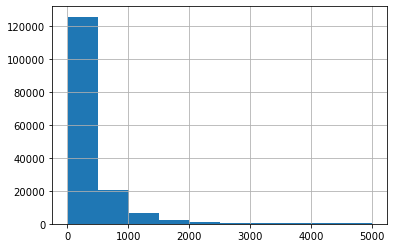

In [10]:
lens.hist();

In [11]:
df.corr().style.background_gradient(cmap='YlGnBu')

,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [12]:
label_cols = [ 'malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
df['label'] = 1-df[label_cols].max(axis=1)
df.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe,label
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df.label.value_counts()

1    143346
0     16225
Name: label, dtype: int64

### CLEANING DATA

In [36]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [38]:
df['length'] = df.comment_text.str.len()
df.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,clean_comment_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264,explanation edits username hardcore metallica ...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112,match background colour seemingly stuck thanks...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233,trying edit constantly removing relevant infor...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622,real suggestion improvement wondered section s...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67,hero chance remember page


In [39]:
# function to filter using POS tagging..
def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [40]:
# Function for data cleaning...
def Processed_data(comments):
    # Replacing email addresses with 'email'
    comments=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', comments)
        
    # Replacing 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    comments=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',comments)
        
    # getting only words(i.e removing all the special characters)
    comments = re.sub(r'[^\w]', ' ', comments) 
        
    # getting only words(i.e removing all the" _ ")
    comments = re.sub(r'[\_]', ' ', comments) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    comments=re.sub(r'\s+[a-zA-Z]\s+', ' ', comments)
    
    # Removing extra whitespaces
    comments=re.sub(r'\s+', ' ', comments, flags=re.I)

    #converting all the letters of the review into lowercase
    comments = comments.lower()
    
    # splitting every words from the sentences
    comments = comments.split()

    # iterating through each words and checking if they are stopwords or not,
    comments=[word for word in comments if not word in set(STOPWORDS)]
    
    # remove empty tokens
    comments = [text for text in comments if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(comments)

    # considering words having length more than 3only
    comments = [text for text in comments if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS ... 
    comments = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]
    comments = ' '.join(comments)
    return comments

In [41]:
df["clean_comment_text"] = df["comment_text"].apply(lambda x: Processed_data(x))


In [42]:
df["clean_comment_text"]


0         explanation edits username hardcore metallica ...
1         match background colour seemingly stuck thanks...
2         trying edit constantly removing relevant infor...
3         real suggestion improvement wondered section s...
4                                 hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                     ashamed horrible thing talk page
159568    spitzer there actual article prostitution ring...
159569       look like actually speedy version deleted look
159570    think understand came idea right away kind com...
Name: clean_comment_text, Length: 159571, dtype: object

In [43]:
df['Clean_length'] =df.clean_comment_text.str.len()
df.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,clean_comment_text,Clean_length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264,explanation edits username hardcore metallica ...,129
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112,match background colour seemingly stuck thanks...,64
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233,trying edit constantly removing relevant infor...,112
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622,real suggestion improvement wondered section s...,315
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67,hero chance remember page,25


In [44]:
df[df['label']==0]

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,clean_comment_text,Clean_length
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,44,cocksucker piss work,20
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,0,319,talk exclusive group taliban good destroying s...,171
16,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,0,57,look come think comming tosser,30
42,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,0,648,antisemmitian archangel white tiger meow greet...,313
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,0,40,fuck filthy mother,18
...,...,...,...,...,...,...,...,...,...,...,...
159494,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,0,1677,previous conversation fucking shit eating libe...,826
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,0,33,mischievious pubic hair,23
159541,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,0,346,absurd edits absurd edits great white shark to...,198
159546,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,0,534,listen delete edits annoyed 2k15 roster confir...,199


In [45]:
df[df['label']==1]

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,clean_comment_text,Clean_length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264,explanation edits username hardcore metallica ...,129
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112,match background colour seemingly stuck thanks...,64
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233,trying edit constantly removing relevant infor...,112
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622,real suggestion improvement wondered section s...,315
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67,hero chance remember page,25
...,...,...,...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1,295,second time asking view completely contradicts...,157
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,1,99,ashamed horrible thing talk page,32
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,1,81,spitzer there actual article prostitution ring...,61
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,1,116,look like actually speedy version deleted look,46


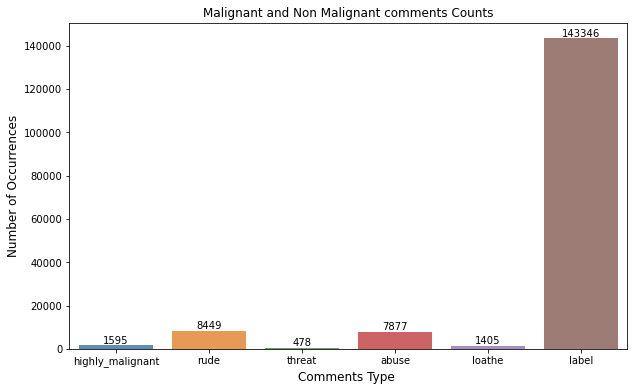

In [46]:
x=df.iloc[:,2:8].sum()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Malignant and Non Malignant comments Counts")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Comments Type ', fontsize=12)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

In [48]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [49]:
data=[]
from nltk.tokenize import word_tokenize
for j,i in enumerate(df['clean_comment_text']):
    a=word_tokenize(i,'english')
    data.append(a)

In [50]:
dictionary = corpora.Dictionary(data)
print(dictionary)

Dictionary(167144 unique tokens: ['closure', 'doll', 'edits', 'explanation', 'hardcore']...)


# EXPLORATORY DATA ANALYSIS

In [51]:
df['label'].value_counts()

1    143346
0     16225
Name: label, dtype: int64

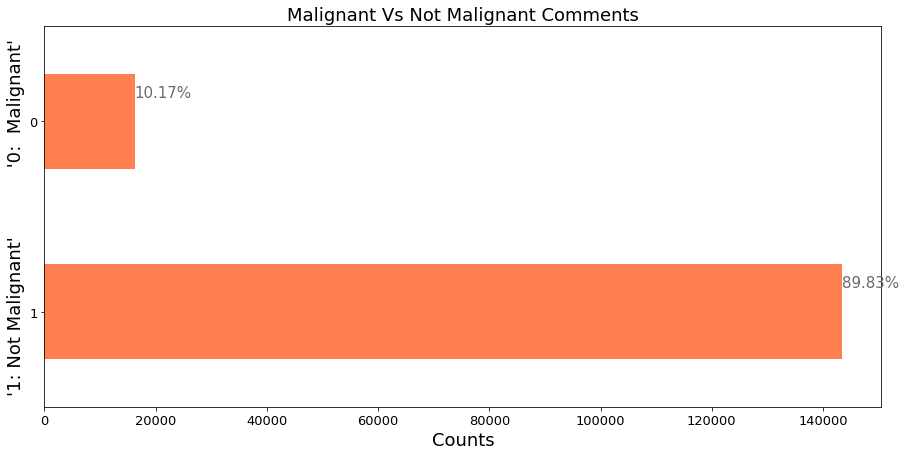

In [52]:
ax = df['label'].value_counts().plot(kind='barh', figsize=(15,7),color="coral", fontsize=13)
ax.set_alpha(0.8)
ax.set_title("Malignant Vs Not Malignant Comments", fontsize=18)
ax.set_xlabel("Counts",  fontsize=18)
ax.set_ylabel("'1: Not Malignant'            '0:  Malignant'", fontsize=18)
totals = []
for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,color='dimgrey')


In [53]:
count1 = Counter(" ".join(df[df['label']==0]["clean_comment_text"]).split()).most_common(200)
count2 = Counter(" ".join(df[df['label']==1]["clean_comment_text"]).split()).most_common(200)
df1=pd.DataFrame()
print("TOP 200 Words in Each Category (Word,Counts)")
df1['Malignant Words']=count1
df1['Not Malignant Words']=count2
df1.head(10)

TOP 200 Words in Each Category (Word,Counts)


,Malignant Words,Not Malignant Words
0,"(fuck, 10080)","(article, 72346)"
1,"(suck, 4696)","(page, 54388)"
2,"(wikipedia, 3939)","(wikipedia, 44659)"
3,"(like, 3937)","(talk, 36421)"
4,"(shit, 3708)","(like, 24492)"
5,"(nigger, 3434)","(source, 21267)"
6,"(fucking, 3337)","(think, 19270)"
7,"(page, 2870)","(time, 17840)"
8,"(hate, 2713)","(know, 17687)"
9,"(faggot, 2496)","(edit, 17247)"


In [55]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def Display_wordcloud(data,title):
    feedbackcloud = WordCloud(
        background_color = 'black',
        max_words = 1000,
        max_font_size = 40, 
        scale = 3,
        random_state = 25
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 10),facecolor='g')
    plt.axis('off')
    plt.imshow(feedbackcloud)
    plt.title(f"{title} words")
    plt.show()

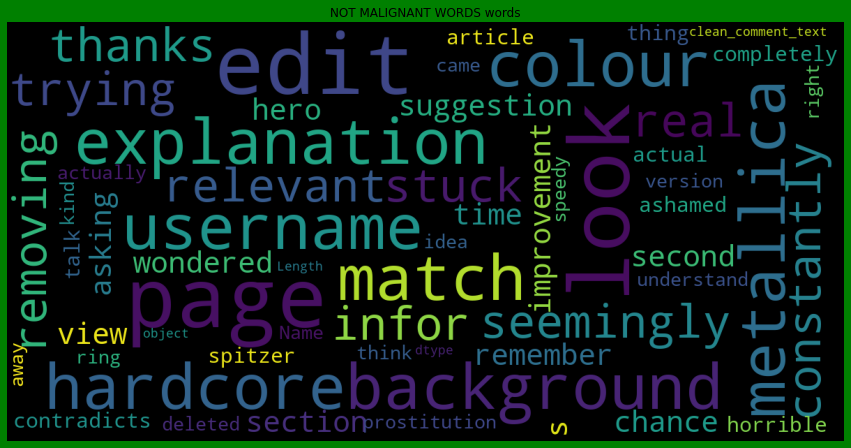

In [56]:
Display_wordcloud(df['clean_comment_text'][df['label']==1],"NOT MALIGNANT WORDS")

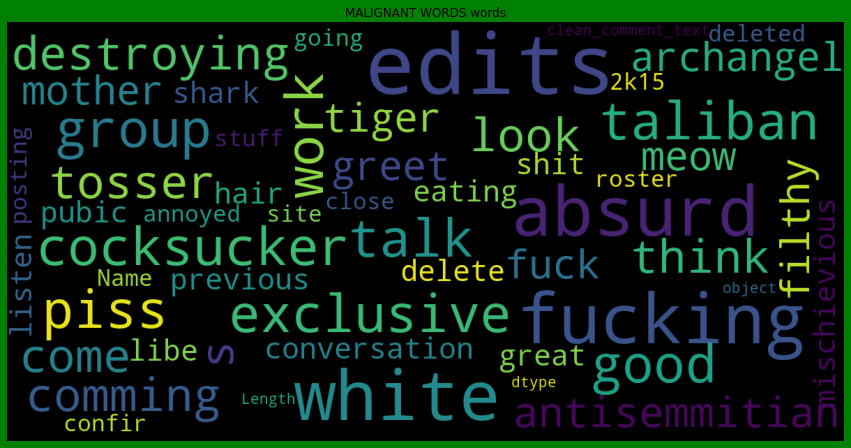

In [57]:
Display_wordcloud(df['clean_comment_text'][df['label']==0],"MALIGNANT WORDS")

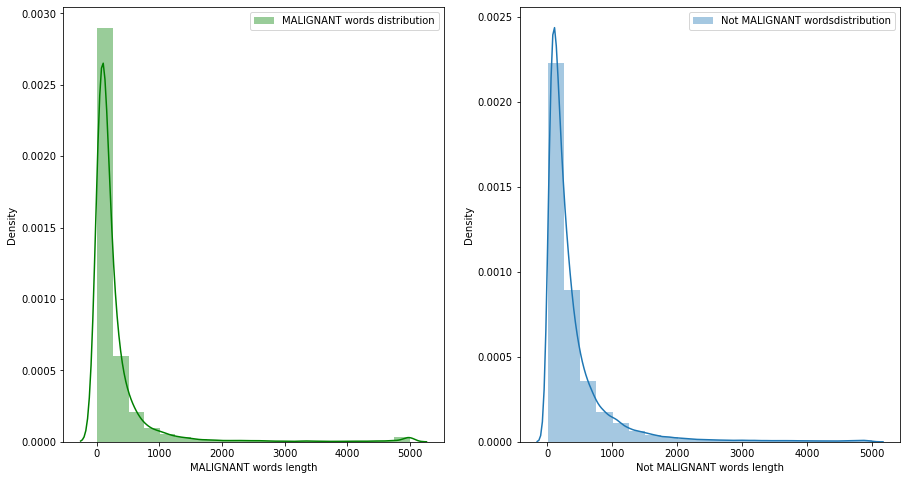

In [58]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df[df['label']==0]['length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(df[df['label']==1]['length'],bins=20,ax=ax[1],label='Not MALIGNANT wordsdistribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

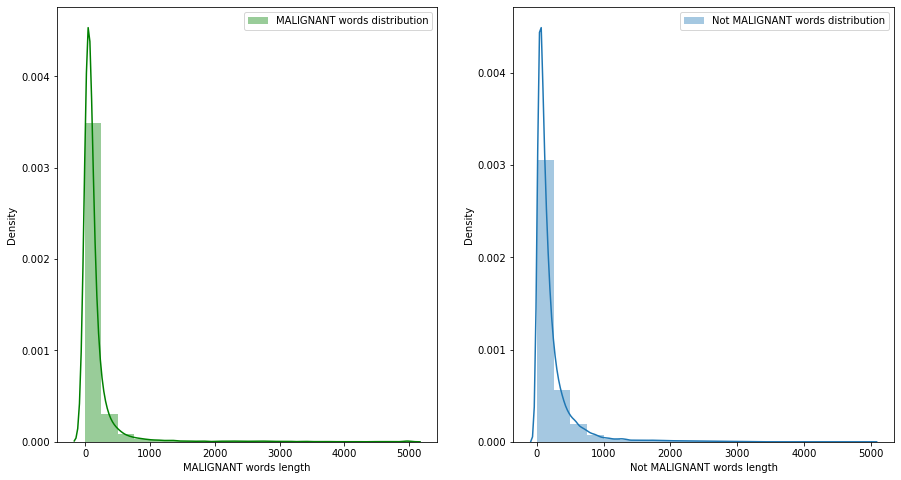

In [59]:
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df[df['label']==0]['Clean_length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(df[df['label']==1]['Clean_length'],bins=20,ax=ax[1],label='Not MALIGNANT words distribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

In [60]:
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)

In [61]:
x=Tf_idf_train(df['clean_comment_text'])

In [62]:
print("Shape of x: ",x.shape)
y = df['label'].values
print("Shape of y: ",y.shape)

Shape of x:  (159571, 43194)
Shape of y:  (159571,)


# Model Training

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import log_loss

LR=LogisticRegression()
MNB=MultinomialNB()
PAC=PassiveAggressiveClassifier()
DT=DecisionTreeClassifier()

In [64]:
models=[]
models.append(('LogisticRegression',LR))
models.append(('MultinomialNB',MNB))
models.append(('PassiveAggressiveClassifier',PAC))
models.append(('DecisionTreeClassifier',DT))

In [65]:
def max_acc_score(clf,x,y):
    max_acc_score=0
    final_r_state=0
    for r_state in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=r_state,stratify=y)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        acc_score=accuracy_score(y_test,y_pred)
        if acc_score > max_acc_score:
            max_acc_score=acc_score
            final_r_state=r_state
    print('Max Accuracy Score corresponding to Random State ', final_r_state, 'is:', max_acc_score)
    print('\n')
    return final_r_state

*************************** LogisticRegression *****************************


LogisticRegression()


Max Accuracy Score corresponding to Random State  44 is: 0.9543574532085561


Learning Score :  0.9570721313530112
Accuracy Score :  0.9543574532085561
Cross Val Score :  0.9647437145554436
roc auc score :  0.7934277979300925


Log loss :  1.5764709396342023


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.59      0.72      4868
           1       0.96      1.00      0.98     43004

    accuracy                           0.95     47872
   macro avg       0.95      0.79      0.85     47872
weighted avg       0.95      0.95      0.95     47872



Confusion Matrix:
 [[ 2879  1989]
 [  196 42808]]





*************************** MultinomialNB *****************************


MultinomialNB()


Max Accuracy Score corresponding to Random State  54 is: 0.9368524398395722


Learning Score :  0.9389072417837223
Accuracy Score :  0.93

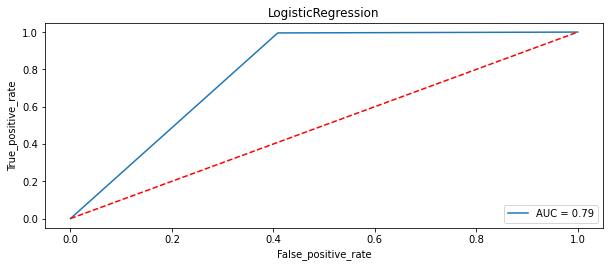

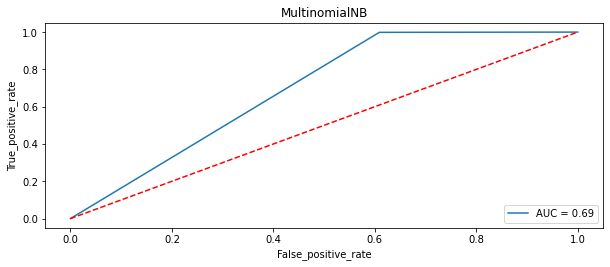

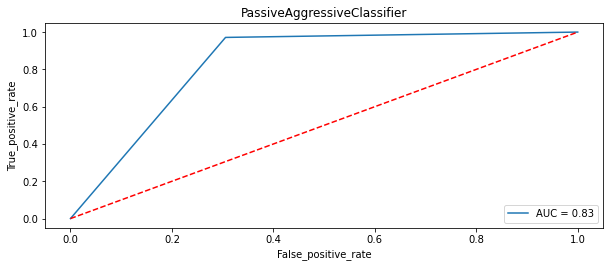

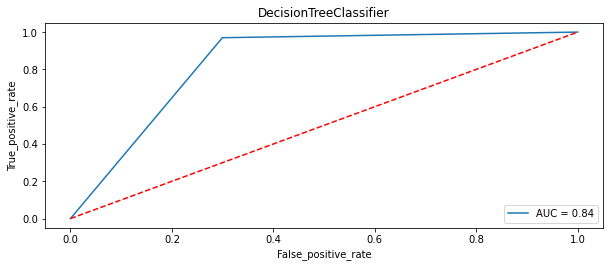

In [67]:
Model=[]
Score=[]
Acc_score=[]
cvs=[]
rocscore=[]
lg_loss=[]

for name,model in models:
    print('***************************',name,'*****************************')
    print('\n')
    Model.append(name)
    print(model)
    print('\n')
    
    r_state=max_acc_score(model,x,y)
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=r_state,stratify=y)
    model.fit(x_train,y_train)
#..............Learning Score...........
    score=model.score(x_train,y_train)
    print('Learning Score : ',score)
    Score.append(score*100)
    y_pred=model.predict(x_test)
    acc_score=accuracy_score(y_test,y_pred)
    print('Accuracy Score : ',acc_score)
    Acc_score.append(acc_score*100)
    
#................Finding Cross_val_score..................    
    cv_score=cross_val_score(model,x,y,cv=10,scoring='roc_auc').mean()
    print('Cross Val Score : ', cv_score)
    cvs.append(cv_score*100)
    
#................Roc auc score...........................    
    false_positive_rate,true_positive_rate, thresholds=roc_curve(y_test,y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    print('roc auc score : ', roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')  
    
    loss = log_loss(y_test,y_pred)
    print('Log loss : ', loss)
    lg_loss.append(loss)
    print('\n')

#................Classification Report...........................      
    print('Classification Report:\n',classification_report(y_test,y_pred))
    print('\n')
    
    print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
    print('\n')
    

    
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    plt.plot(false_positive_rate,true_positive_rate,label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True_positive_rate')
    plt.xlabel('False_positive_rate')
    print('\n\n')

In [72]:
result=pd.DataFrame({'Model': Model,'Learning Score': Score,'Accuracy Score': Acc_score,'Cross Val Score':cvs,
                     'Roc_Auc_curve':rocscore,'Log_Loss':lg_loss}) 
result.style.background_gradient(cmap='YlGnBu')

,Model,Learning Score,Accuracy Score,Cross Val Score,Roc_Auc_curve,Log_Loss
0,LogisticRegression,95.707213,95.435745,96.474371,79.342780,1.576471
1,MultinomialNB,93.890724,93.685244,92.949123,69.487688,2.181089
2,PassiveAggressiveClassifier,99.019687,94.322360,93.467391,83.286416,1.961012
3,DecisionTreeClassifier,99.827214,94.245070,83.454622,83.516652,1.987707


# Final Model

In [73]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=57,test_size=.30,stratify=y)
PAC=PassiveAggressiveClassifier()
PAC.fit(x_train,y_train)
PAC.score(x_train,y_train)
PACpred=PAC.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,PACpred))
print('Log loss : ', log_loss(y_test,PACpred))
print('Confusion Matrix:',confusion_matrix(y_test,PACpred))
print('Classification Report:','\n',classification_report(y_test,PACpred))

Accuracy Score: 0.9458347259358288
Log loss :  1.8708272766911556
Confusion Matrix: [[ 3372  1496]
 [ 1097 41907]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.69      0.72      4868
           1       0.97      0.97      0.97     43004

    accuracy                           0.95     47872
   macro avg       0.86      0.83      0.85     47872
weighted avg       0.94      0.95      0.94     47872



(2.5, -0.5)

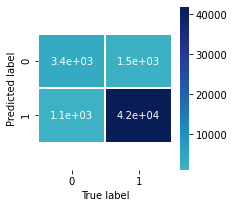

In [74]:
fig, ax =plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, PACpred),annot=True,linewidths=1,center=0,cmap='YlGnBu')
plt.xlabel("True label")
plt.ylabel("Predicted label")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Text(0.5, 1.0, 'PassiveAggressiveClassifier')

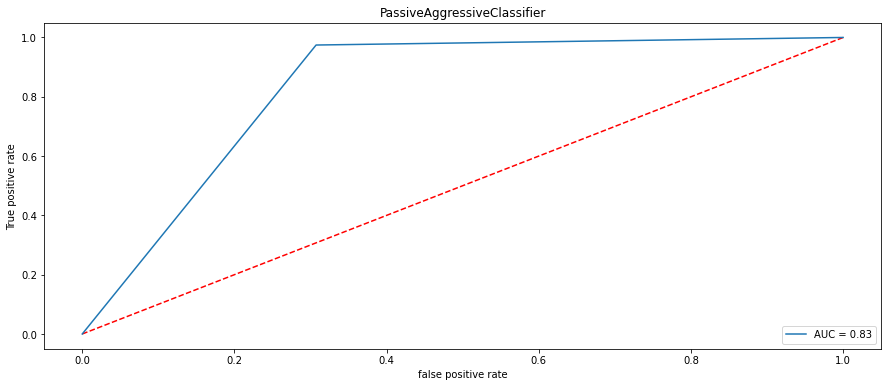

In [75]:
# Roc-Auc score
f,ax = plt.subplots(figsize = (15,6))
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, PACpred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, PACpred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('PassiveAggressiveClassifier')

In [76]:
def Tf_idf_test(text):
    tfid = TfidfVectorizer(max_features=43194,smooth_idf=False)
    return tfid.fit_transform(text)

In [77]:
# Loading the test data..
df_test=pd.read_csv('test.csv')

df_test["clean_comment_text"] = df_test["comment_text"].apply(lambda x: Processed_data(x))
x_testing_data=Tf_idf_test(df_test['clean_comment_text'])

In [78]:
x_testing_data.shape

(153164, 43194)

In [71]:
Prediction=PAC.predict(x_testing_data)
df_test['Predicted values']=Prediction
df_test

,id,comment_text,clean_comment_text,Predicted values
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succesful whats hating mofuckas bit...,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,title fine,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton lapland,1
3,00017563c3f7919a,":If you have a look back at the source, the in...",look source information updated correct form g...,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,anonymously edit article,1
...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",totally agree stuff long crap,1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,throw field home plate faster throwing direct ...,1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",okinotorishima category change agree correct g...,1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",founding nation germany return similar israel ...,1


In [79]:
df_test.to_csv('Malignant-Comments-Classifier.csv')

In [80]:
import joblib
joblib.dump(PAC,'Malignant-Comments-Classifier.pkl')

['Malignant-Comments-Classifier.pkl']